## Face Averaging

### How to create an average face using OpenCV ?

- Step 1 : Facial Feature Detection
- Step 2 : Coordinate Transformation
- Step 3 : Face Alignment
- Step 4 : Face Averaging

### Similarity Transformation
A Similarity transform is an Affine transform without any shear

#### Step 1 : Facial Feature Detection
Using Dlib we can calculate 68 facial landmarks

### Step 2 : Coordinate Transformation
Similarity Transform: To find the similarity transform that will transform the points from the input image coordinates to the output image coordinates. To do this, we can use `estimateAffinePartial2D` function.

In [6]:
import math
import cv2
import dlib
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH

sys.path.append(os.path.join(os.getcwd(), '../week1'))

import faceBlendCommon as fbc

%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [42]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.

def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  # Convert this to scaler list
  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int32(xin), np.int32(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int32(xout), np.int32(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
  return tform[0]

In [43]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  eyecornerSrc = [pointsIn[36], pointsIn[45]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  
  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, 
                      (pointsIn.shape[0], 1, pointsIn.shape[1]))
  
  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, 
                        (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut   

### Step 3: Face Alignment

In [44]:
# Warps an image in a piecewise affine manner.
# The warp is defined by the movement of landmark points specified by
# pointsIn to a new location specified by pointsOut. 
# The triangulation beween points is specified by 
# their indices in delaunayTri.
def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Warp each input triangle to output triangle.
  # The triangulation is specified by delaunayTri
  for j in range(0, len(delaunayTri)):
    # Input and output points corresponding to jth triangle
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pIn = constrainPoint(pIn, w, h)

      # Extract a vertex of the output triangle
      pOut = pointsOut[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pOut = constrainPoint(pOut, w, h)

      # Push the input vertex into input triangle
      tin.append(pIn)
      # Push the output vertex into output triangle
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut

### Step 3: Face Averaging

In [9]:
# Read all jpg image paths in folder.
def readImagePaths(path):
  # Create array of array of images.
  imagePaths = []
  # List all files in the directory and read points from text files 
  for filePath in sorted(os.listdir(path)):
    fileExt = os.path.splitext(filePath)[1]
    if fileExt in [".jpg", ".jpeg"]:
      print(filePath)

      # Add to array of images
      imagePaths.append(os.path.join(path, filePath))

  return imagePaths

In [10]:
# Landmark model location
PREDICTOR_PATH = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"

In [11]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

dirName = DATA_PATH + "images/presidents"

In [16]:
# Read all images
imagePaths = readImagePaths(dirName)

if len(imagePaths) == 0:
    print('No images found with extension jpg or jpeg')

barak-obama.jpg
bill-clinton.jpg
george-h-bush.jpg
george-w-bush.jpg
jimmy-carter.jpg
ronald-regan.jpg


In [13]:
# Read images and perform landmark detection.
images = []
allPoints = []

for imagePath in imagePaths:
    im = cv2.imread(imagePath)
    if im is None:
        print("image:{} not read properly".format(imagePath))
    else:
        points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
        if len(points) > 0:
            allPoints.append(points)

            im = np.float32(im)/255.0
            images.append(im)
        else:
            print("Couldn't detect face landmarks")

In [14]:
# Dimensions of output image
w = 600
h = 600

# 8 Boundary points for Delaunay Triangulation
boundaryPts = fbc.getEightBoundaryPoints(h, w)

numImages = len(imagePaths)
numLandmarks = len(allPoints[0])

# Variables to store normalized images and points.
imagesNorm = []
pointsNorm = []

# Initialize location of average points to 0s
pointsAvg = np.zeros((numLandmarks, 2), dtype=np.float32)

# Warp images and trasnform landmarks to output coordinate system,
# and find average of transformed landmarks.
for i, img in enumerate(images):

    points = allPoints[i]
    points = np.array(points)

    img, points = fbc.normalizeImagesAndLandmarks((h, w), img, points)

    # Calculate average landmark locations
    pointsAvg = pointsAvg + (points / (1.0*numImages))

    # Append boundary points. Will be used in Delaunay Triangulation
    points = np.concatenate((points, boundaryPts), axis=0)

    pointsNorm.append(points)
    imagesNorm.append(img)

# Append boundary points to average points.
pointsAvg = np.concatenate((pointsAvg, boundaryPts), axis=0)


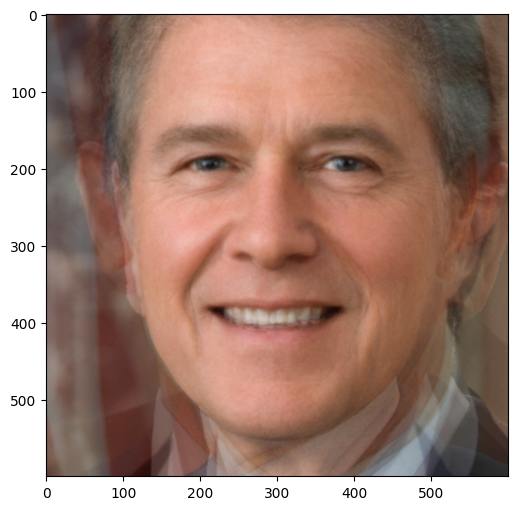

In [15]:
# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True

# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Delaunay triangulation
rect = (0, 0, w, h)
dt = calculateDelaunayTriangles(rect, pointsAvg)

# Output image
output = np.zeros((h, w, 3), dtype=np.float32)

# Warp input images to average image landmarks
for i in range(0, numImages):

    imWarp = fbc.warpImage(imagesNorm[i], pointsNorm[i], 
                            pointsAvg.tolist(), dt)

    # Add image intensities for averaging
    output = output + imWarp

# Divide by numImages to get average
output = output / (1.0*numImages)

# Display result
plt.imshow(output[:,:,::-1])
plt.show()